In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil



# download data

In [ ]:
filename = "../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

# data loader

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Water' : [ 41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60],
                            'Vegetation' : [ 58, 221, 254],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0]

        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)

            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512))
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset', training = True, transform= t)

len(dataset)

72

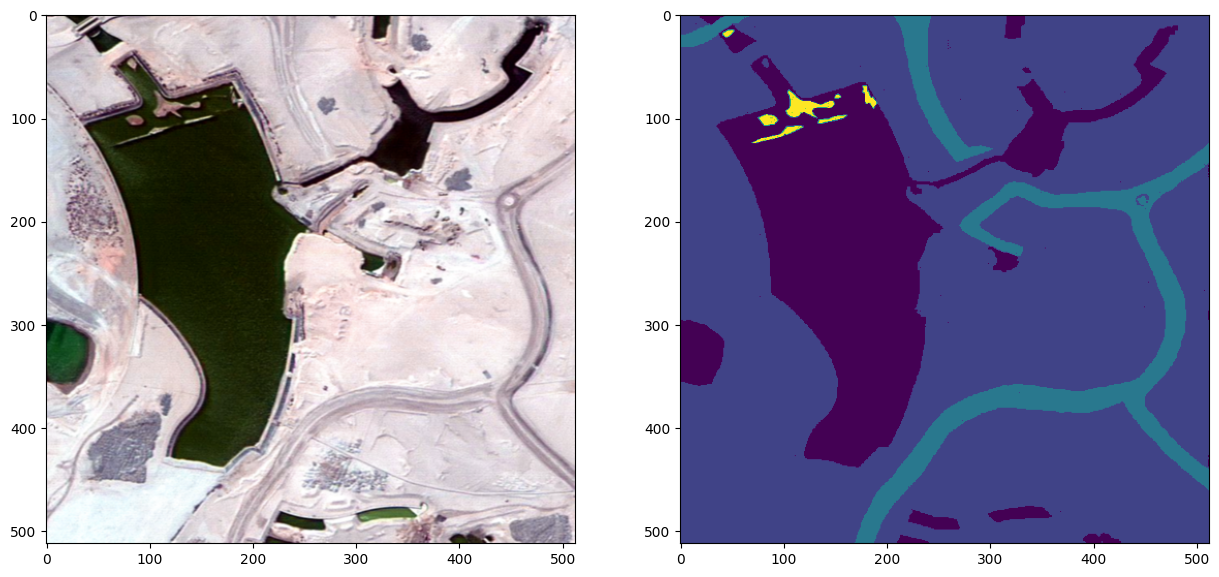

In [ ]:
d = dataset[1]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [ ]:

test_num = int(0.1 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=0)

test data : 7


In [ ]:
Building (#3C1098): Dark Purple
Land (unpaved area) (#8429F6): Purple
Road (#6EC1E4): Light Blue
Vegetation (#FEDD3A): Yellow
Water (#E2A929): Golden Yellow
Unlabeled (#9B9B9B): Grey






In [ ]:
##################################### for GPU ###########################

def get_default_device():
    # pick the gpu if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #move tensors to choosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader():
    # move the batches of the data to our selected device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()

train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

#########################################################################

In [ ]:
device

device(type='cpu')

# U-net model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Vision Transformer

In [ ]:
pip install einops

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 512, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.vit = ViT(image_size = 32,patch_size = 8,dim = 2048, depth = 2, heads = 16,mlp_dim = 12,channels = 512) #dim%head=0
        self.vit_conv = nn.Conv2d(32,512,kernel_size = 1,padding = 0) #to increase the number of channels
        self.vit_linear = nn.Linear(64,1024)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        #applying Vision Transformer
        x6 = self.vit(x5) #[4,2048]
        x6 = torch.reshape(x6,(-1,32,8,8)) #[4,32,8,8]
        x7 = self.vit_conv(x6) #[4,512,8,8]
        x8 = self.vit_linear(torch.reshape(x7,(-1,512,64))) #[4,512,1024]
        x9 = torch.reshape(x8,(-1,512,32,32))

        x = self.up1(x9, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
criterion = FocalLoss(gamma=3/4).to(device)

# training

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc
def precision(y, pred_mask, classes = 6):
    precision_list = [];
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

def recall(y, pred_mask, classes = 6):
    recall_list = []
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [ ]:
min_loss = torch.tensor(float('inf'))

model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 5
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                 np.mean(loss_list),
                                                                                                 np.mean(acc_list),
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))

  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/5] [Batch 16/17] [Loss: 1.207776 (1.011018)] epoch 0 - loss : 1.01102 - acc : 0.60 - val loss : 2.51208 - val acc : 0.34
[Epoch 1/5] [Batch 16/17] [Loss: 1.325194 (0.820650)] epoch 1 - loss : 0.82065 - acc : 0.67 - val loss : 0.78242 - val acc : 0.68
[Epoch 2/5] [Batch 16/17] [Loss: 0.603636 (0.692717)] epoch 2 - loss : 0.69272 - acc : 0.71 - val loss : 0.72663 - val acc : 0.69
[Epoch 3/5] [Batch 16/17] [Loss: 2.180784 (0.784352)] epoch 3 - loss : 0.78435 - acc : 0.67 - val loss : 0.65506 - val acc : 0.70
[Epoch 4/5] [Batch 16/17] [Loss: 1.140521 (0.713330)] epoch 4 - loss : 0.71333 - acc : 0.70 - val loss : 0.69283 - val acc : 0.72


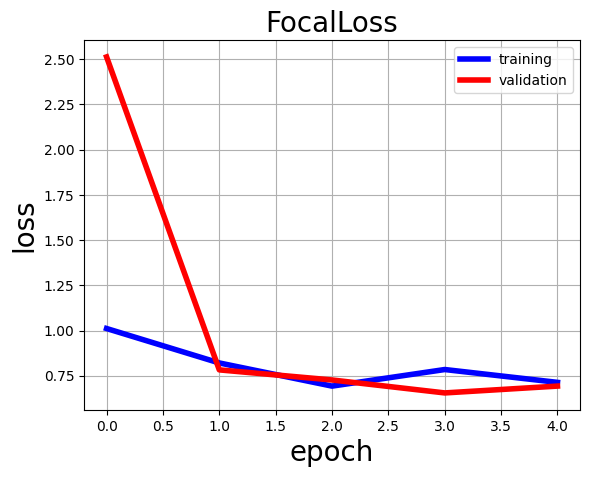

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

# testing

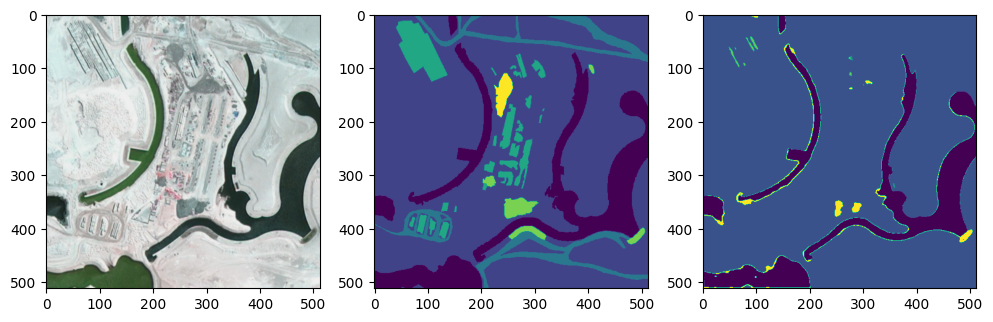

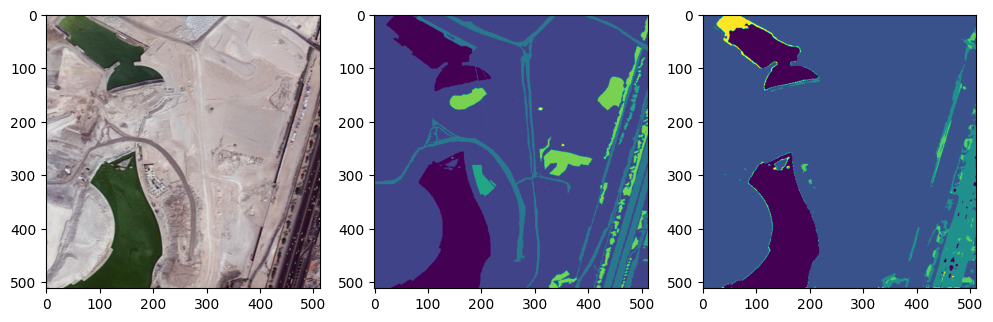

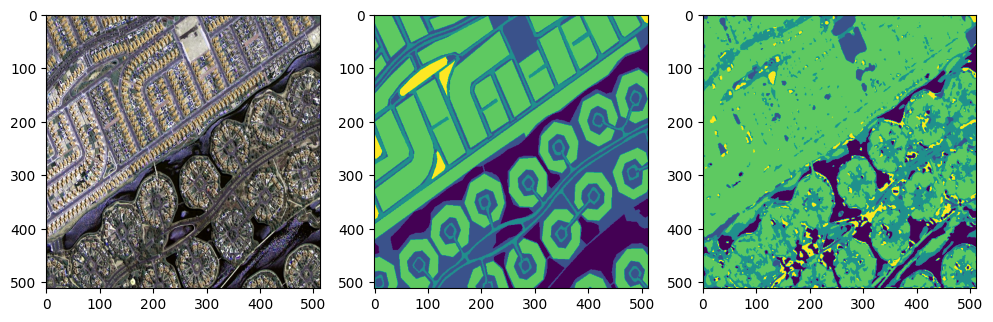

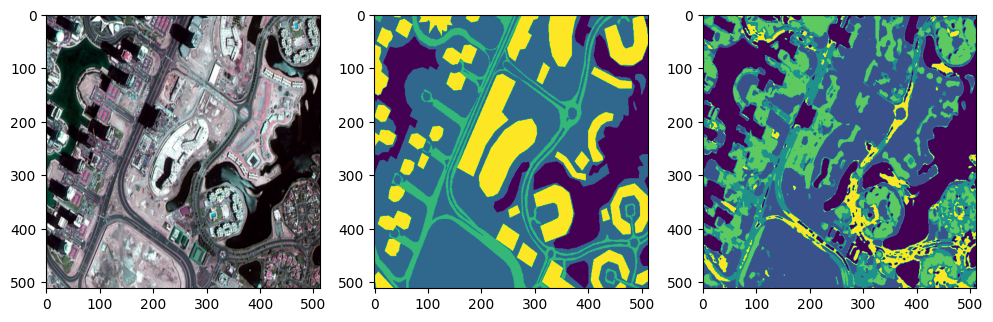

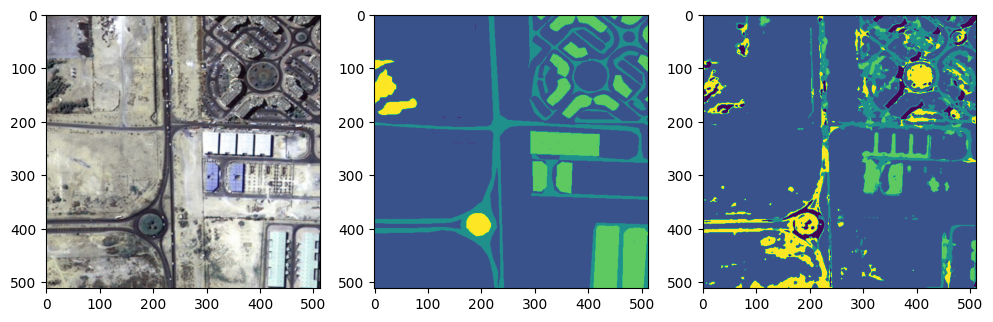

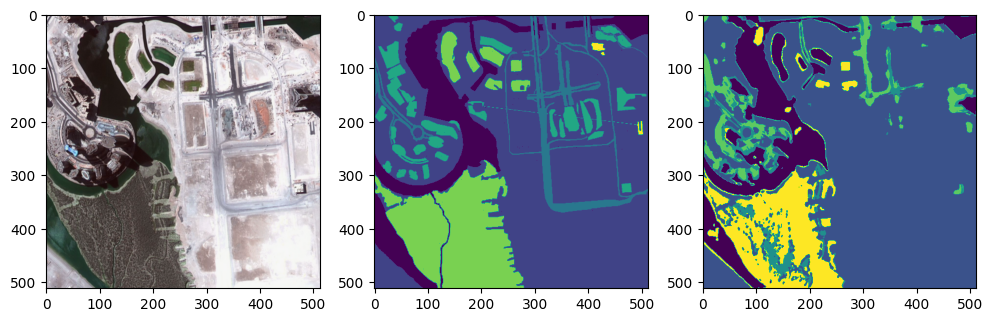

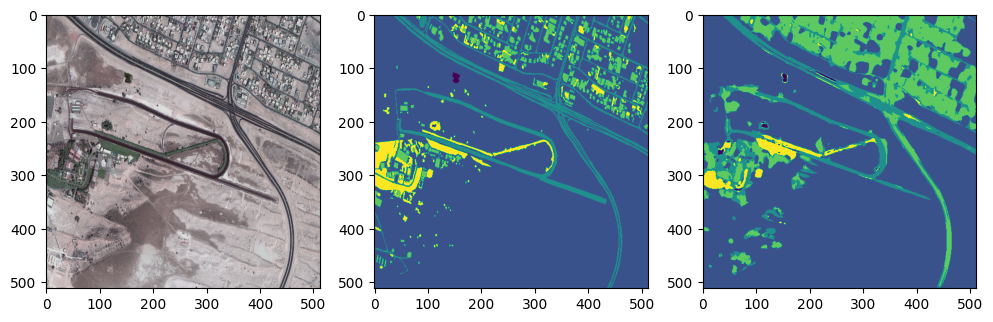

In [ ]:
model.eval()
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j].cpu()

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

In [ ]:
def precision(y, pred_mask, classes = 6):
    precision_list = [];
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

def recall(y, pred_mask, classes = 6):
    recall_list = []
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [ ]:
pred_list = []
gt_list = []
precision_list = []
recall_list = []
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        precision_list.append(precision(y[j],result))
        recall_list.append(recall(y[j],result))

In [ ]:
np.nanmean(precision_list,axis = 0)

<ipython-input-23-da8def3ccff3>:1: RuntimeWarning: Mean of empty slice
  np.nanmean(precision_list,axis = 0)


array([0.59525632, 0.78857106, 0.31671058, 0.52205241, 0.26417324,
              nan])

In [ ]:
np.nanmean(recall_list,axis = 0)

array([0.66914713, 0.76430098, 0.30288977, 0.3714971 , 0.30789449,
       0.        ])

In [ ]:
final_precision = np.nanmean(precision_list,axis = 0)
sum(final_precision[:-1])/5

<ipython-input-25-0a136974a8da>:1: RuntimeWarning: Mean of empty slice
  final_precision = np.nanmean(precision_list,axis = 0)


0.4973527218073806

In [ ]:
final_recall = np.nanmean(recall_list,axis = 0)
sum(final_recall)/5

0.48314589506515493

In [ ]:
#THANKS FOR READING